## Application: Labor Participation
---

#### Variables:

+ work - participation in 1975 ? (error: "no" must be "yes")
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display

#### Labor participation

$$
 y_i = \begin{cases} 1, & \text{work}; \\ 0, & \text{not work}. \end{cases}
$$

$$
 \log\frac{\mu}{1-\mu}
 = \text{constant}
 + \beta_1(\text{hoursh}\times\text{wageh}\div 1000)
 + \beta_2\text{univ}
 + \beta_3\text{city}
 + \beta_4\text{experience}
 + \beta_5\text{child6}
 + \beta_6\text{unemprate}
$$

where

$$
 \text{univ} = \begin{cases} 1, & \text{university gradaute or higher};\\ 0, & \text{otherwise}. \end{cases}.
$$


In [2]:
data = pd.read_csv('Mroz.csv', index_col=0)
earnings = data['hoursh'].values * data['wageh'].values / 1000
age = data['agew'].values
dummy_univ = (data['educw'].values >= 16)
dummy_city = data['city'].replace(['yes', 'no'], [1, 0]).values
y = data['work'].replace(['yes', 'no'], [0, 1]).values
X = np.hstack((np.vstack((np.ones(y.size), earnings, dummy_univ, dummy_city)).T,
              data[['experience', 'child6', 'unemprate']].values))
var_names = ['constant', 'earnings', 'university', 'city', 'experience', 'child6', 'unemprate']

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:55<00:00, 433.00draws/s]


In [4]:
post_stats = pm.summary(trace)
post_stats.index = var_names
display(post_stats)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
constant,-0.067533,0.303618,0.002541,-0.658571,0.520560,14816.031293,1.000109
earnings,-0.021851,0.009832,0.000069,-0.041404,-0.003413,20446.560872,0.999920
university,1.268377,0.275849,0.001796,0.724555,1.802236,23160.304266,0.999994
city,-0.004252,0.180132,0.001101,-0.354423,0.351000,23562.918501,1.000003
experience,0.094846,0.012388,0.000073,0.071350,0.119489,23034.121500,0.999982
child6,-0.764002,0.167680,0.001032,-1.087325,-0.434422,26776.327020,0.999919
unemprate,-0.024214,0.026859,0.000206,-0.078041,0.027834,17597.128063,1.000028


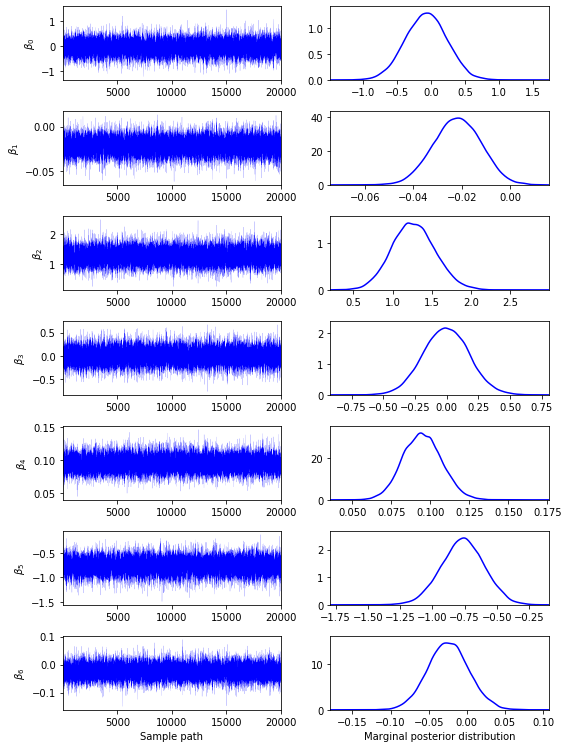

In [5]:
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for index in range(k):
    mc_trace = trace['b'][:, index]
    x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
    x_max =  mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 0].plot(mc_trace, 'b-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel('$\\beta_{:d}$'.format(index))
    ax[index, 1].plot(x, posterior, 'b-')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
ax[k-1, 0].set_xlabel('Sample path')
ax[k-1, 1].set_xlabel('Marginal posterior distribution')
plt.tight_layout()
# plt.savefig('ms_fig_labor_logit.png', dpi=300)
plt.show()